In [34]:
import os, glob, cv2, random
import numpy as np
import pandas as pd
from tqdm import tqdm

In [35]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *

In [36]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from sklearn.model_selection import train_test_split

In [38]:
df = pd.read_csv("full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


Step 3. Extracting Myopia & Normal information from the dataset

Myopia images

In [39]:
def has_myopia(text):
    if "pathological myopia" in text:
        return 1
    else:
        return 0

In [40]:
df["left_myopia"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_myopia(x))
df["right_myopia"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_myopia(x))
left_myopia = df.loc[(df.M ==1) & (df.left_myopia == 1)]["Left-Fundus"].values
left_myopia[:15]

array(['13_left.jpg', '18_left.jpg', '35_left.jpg', '106_left.jpg',
       '144_left.jpg', '145_left.jpg', '174_left.jpg', '225_left.jpg',
       '379_left.jpg', '401_left.jpg', '481_left.jpg', '504_left.jpg',
       '525_left.jpg', '741_left.jpg', '771_left.jpg'], dtype=object)

In [41]:
right_myopia = df.loc[(df.M ==1) & (df.right_myopia == 1)]["Right-Fundus"].values
right_myopia[:15]

array(['13_right.jpg', '16_right.jpg', '18_right.jpg', '46_right.jpg',
       '54_right.jpg', '86_right.jpg', '106_right.jpg', '145_right.jpg',
       '214_right.jpg', '233_right.jpg', '390_right.jpg', '401_right.jpg',
       '475_right.jpg', '504_right.jpg', '525_right.jpg'], dtype=object)

In [42]:
print("Number of images in left myopia: {}".format(len(left_myopia)))
print("Number of images in right myopia: {}".format(len(right_myopia)))

Number of images in left myopia: 216
Number of images in right myopia: 241


Normal images

In [43]:

left_normal = df.loc[(df.M ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(230,random_state=42).values
right_normal = df.loc[(df.M ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(230,random_state=42).values
myopia = np.concatenate((left_myopia,right_myopia),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)
print(left_normal[:15])
print(len(myopia),len(normal))

['112_left.jpg' '3009_left.jpg' '2919_left.jpg' '3422_left.jpg'
 '3110_left.jpg' '2564_left.jpg' '2467_left.jpg' '3348_left.jpg'
 '2451_left.jpg' '2388_left.jpg' '2831_left.jpg' '2855_left.jpg'
 '3193_left.jpg' '2718_left.jpg' '2343_left.jpg']
457 460


Step 4: Creating dataset from images

In [44]:

image_set_dir = "preprocessed_images"

image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(image_set_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset
dataset = create_dataset(myopia, 1)

100%|████████████████████████████████████████████████████████████████████████████████| 457/457 [00:05<00:00, 85.26it/s]


In [45]:
len(dataset)

454

In [46]:
dataset = create_dataset(normal, 0)

100%|███████████████████████████████████████████████████████████████████████████████| 460/460 [00:04<00:00, 108.23it/s]


In [47]:
len(dataset)

914

Image presentation

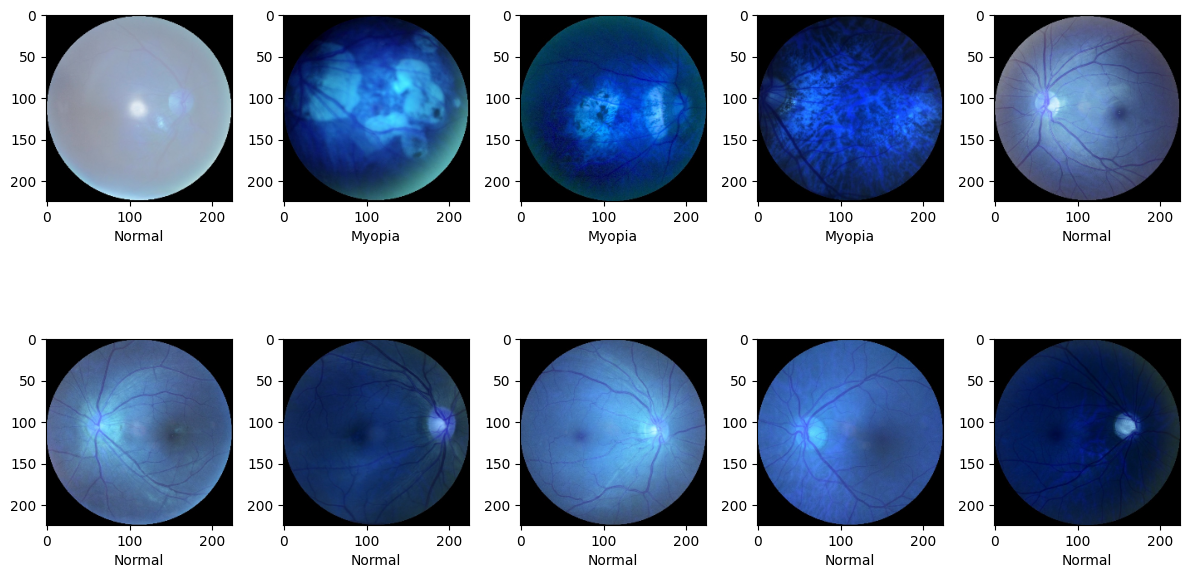

In [48]:

plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Myopia"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

Dividing dataset into x (features) & y (target)

In [49]:

x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

Step 5: Creating Model

In [50]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [51]:
for layer in vgg.layers:
    layer.trainable = False


In [52]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [53]:
from keras.models import Model
from keras.layers import Input
img_height = 224
img_width = 224
img_channels = 3  # Assuming RGB images

# Assuming input shape for vgg model is (img_height, img_width, img_channels)
input_shape = (img_height, img_width, img_channels)
input_tensor = Input(shape=input_shape)
vgg_output = vgg(input_tensor)

flatten_layer = Flatten()(vgg_output)
dense_layer = Dense(1, activation="sigmoid")(flatten_layer)

model = Model(inputs=input_tensor, outputs=dense_layer, name="sequential")

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,049,473 (76.48 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [54]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

Early stopping for statistical optimization

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


In [56]:
checkpoint = ModelCheckpoint("vgg19.keras",  # Change filepath to end with .keras
                             monitor="val_acc",
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False)

earlystop = EarlyStopping(monitor="val_acc",
                          patience=5,
                          verbose=1,
                          mode='max')

history = model.fit(x_train, y_train,
                    
                    batch_size=32,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    callbacks=[checkpoint, earlystop])


Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 501s 22s/step - accuracy: 0.7844 - loss: 1.8362 - val_accuracy: 0.9781 - val_loss: 0.2382
Epoch 2/5


C:\Users\yellaveni sathish\OneDrive\Desktop\JUPYTER\myenv\lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
C:\Users\yellaveni sathish\OneDrive\Desktop\JUPYTER\myenv\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 505s 22s/step - accuracy: 0.9711 - loss: 0.2737 - val_accuracy: 0.9727 - val_loss: 0.2066
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 460s 20s/step - accuracy: 0.9960 - loss: 0.0300 - val_accuracy: 0.9836 - val_loss: 0.0974
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 453s 20s/step - accuracy: 1.0000 - loss: 2.0445e-04 - val_accuracy: 0.9945 - val_loss: 0.0877
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 438s 19s/step - accuracy: 1.0000 - loss: 2.8243e-05 - val_accuracy: 0.9945 - val_loss: 0.0878


In [57]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 89s 15s/step - accuracy: 0.9975 - loss: 0.0451
loss: 0.08776161074638367
Accuracy: 0.994535505771637


In [58]:
pred_y=model.predict(x_test)
y_pred=(pred_y > 0.5).astype("int32")

6/6 ━━━━━━━━━━━━━━━━━━━━ 88s 14s/step


In [59]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.994535519125683

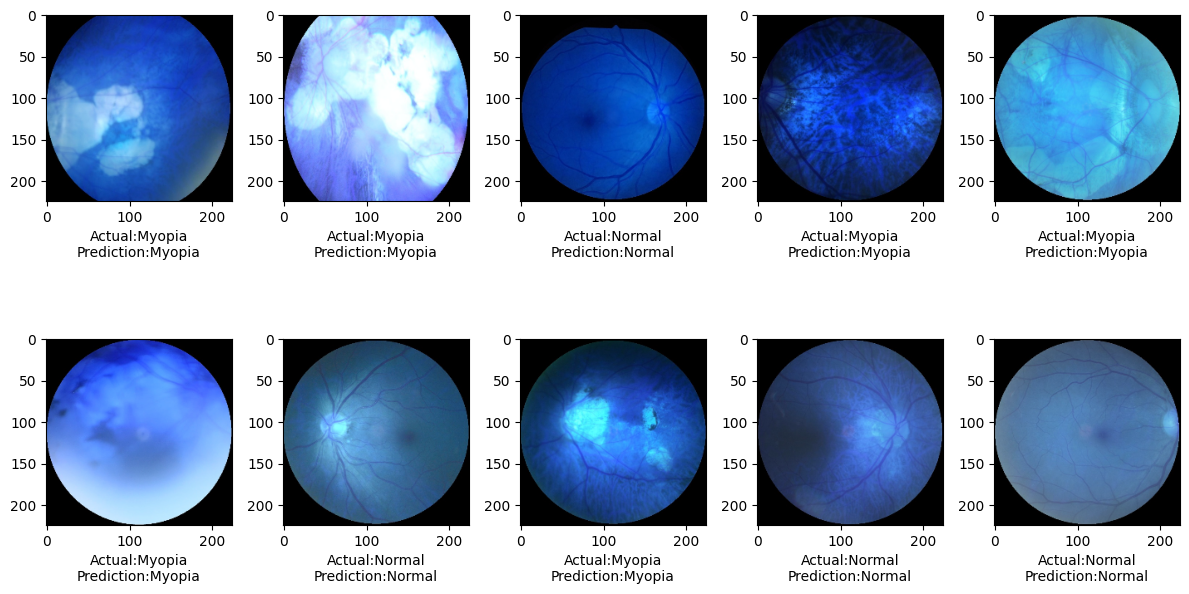

In [60]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Myopia"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Myopia"


    
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))

plt.tight_layout() 

In [62]:
# Save the entire model in the native Keras format
model.save("vgg19_myopia_prediction_model.keras")

print("Model saved successfully in native Keras format.")


Model saved successfully in native Keras format.
